# TODO
* Add RTs into model
    * CHECK Avoid NaNs in RL model -> Remove fast RTs earlier by shifting up trials
    * CHECK Calculate an RT modulator rta (for $\alpha$) or rtb (for $\beta$) 
        * will be multiplied with $\alpha$ / $\beta$
        * is 1 when parameter is not set; is RT * parameter otherwise
        * needs to be [0, 1]
    * Figure out why it's not working... 
        * CHECK Why can't I print rta, rtb, or any parameter at all any more?
        * 
    * Modulates alpha? -> dopamine = RPE
    * Modulates beta? -> dopamine = response vigor
* Is the RT model better than the no-RT model? -> Plot (W)AIC etc.
* Hierarchical fitting (with or without RTs)
    * Baseline model: $\theta \sim 1$ (just regular group-level priors)
    * Age group differences: $\theta \sim agegroup$ (two groups based on agegroup)
    * Meta-learning: $\theta \sim session$ (linear effect of session? quadratic?)
    * Age group and meta-learning: $\theta \sim session + agegroup$ (how do I specify within- vs between-participant factors? {session vs agegroup)
    * Differences in meta-learning based on agegroup: $\theta \sim session \times agegroup$
    * Model comparison using WAIC

## In progress
* RT regression model
    * DONE choice ~ prev_choice + prev_reward + prev_RT
    * DONE run hierarchical

## Done
* DONE Run RL models on new, clean data
    * DONE Exclude for 10 sessiosn and 500 trials
    * DONE Make sure I'm doing everything I'm doing in the notebook
    * DONE Could I just use true_dat?
* DONE Plot results using old notebook
* CHECK Split pre-processing into separate notebook
* CHECK Basic RT plots
    * CHECK RT over sessions, blocks, trials
    * CHECK RT differences reward vs no-reward; correct vs incorrect

I think you ran the best model for visualization. To test statistical significance, I think it might be good to run a model like `action ~ reward * noreward * n_ago * rt_quartile`, i.e., instead of having reward_1ago_rtquart0, reward_2ago_rtquart0, reward_1ago_rtquart1, reward_2ago_rtquart1, noreward_1ago_rtquart0, noreward_2ago_rtquart0, etc. etc., we'd have just four predictors: One for reward, one for noreward, one for n_ago, and one for RT quartile. This way we could test the effect of just reward (should be positive, i.e., mice should be more likely to select rewarded actions again), just noreward (should be negative), just rt_quartile (should have no main effect), and just n_ago (also no main effect). Then we'd expect interactions between n_ago and reward/noreward (showing that the effect of reward and noreward decays with delay), between rt_quartiles, and reward/noreward (showing that the effects of reward/noreward differ based on RTs), and potentially a triple interaction between rt_quartiles, n_ago, and reward/noreward (showing that the effect of 

I think there is a better way to run this model by splitting reward, noreward, and n_ago into separate regressors. This way we could test the overall effect of reward (should be positive) and of noreward (should be negative), and interactions between reward/noreward and n_ago (should be negative, showing that the effects of reward and noreward decay with delay), and between reward/noreward and rt_quartiles (should also be negative, showing that the effects of reward / noreward decrease with longer RTs). We could even treat RTs as a continuous variable, rather than splitting it into arbitrary groups, and for extra power.

In [91]:
a = np.array([1, 2])
a = a / a
a

array([1., 1.])

In [75]:
np.mean(true_dat.rt < 0.1)

0.01893298969072165

In [76]:
a = true_dat.rt - min(true_dat.rt)
a /= max(a)
a.describe()

count    183057.000000
mean          0.161869
std           0.132792
min           0.000000
25%           0.096471
50%           0.120746
75%           0.172548
max           1.000000
Name: rt, dtype: float64

In [77]:
np.log(true_dat.rt).describe()

count    183057.000000
mean         -0.649518
std           0.665778
min          -5.521461
25%          -0.942891
50%          -0.720518
75%          -0.366004
max           1.386294
Name: rt, dtype: float64

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 307'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 10943 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


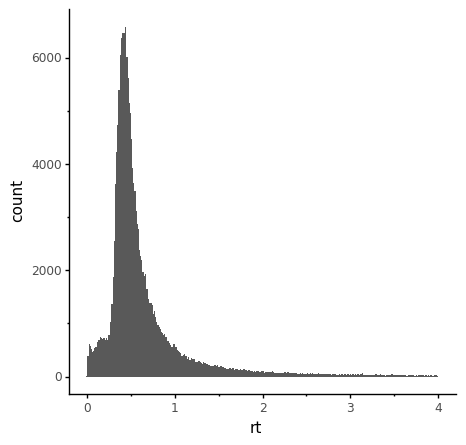

<ggplot: (130467432831)>

In [82]:
(gg.ggplot(true_dat, gg.aes('rt'))
 + gg.geom_histogram()
)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 299'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_bin : Removed 10943 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


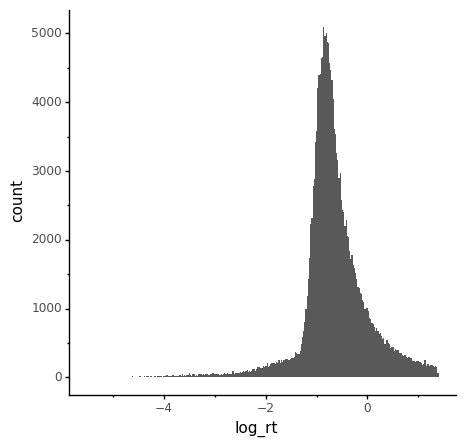

<ggplot: (130494537094)>

In [84]:
true_dat['log_rt'] = np.log(true_dat.rt)
(gg.ggplot(true_dat, gg.aes('log_rt'))
 + gg.geom_histogram()
)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 10943 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


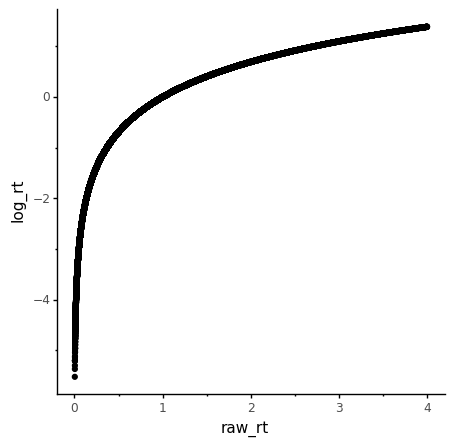

<ggplot: (-9223371906387299861)>

In [81]:
dat = pd.DataFrame({'raw_rt': true_dat.rt, 'log_rt': np.log(true_dat.rt)})
dat
(gg.ggplot(dat, gg.aes('raw_rt', 'log_rt'))
 + gg.geom_point()
)

# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import statsmodels.formula.api as smf

from Functions import get_info_from_fullID, add_meta_column, sigmoid, get_session

In [2]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
# save_or_load_true_mouse_dat = 'load'  # 'save', 'load'
# save_or_load_sim_mouse_dat = 'save'  # 'save', 'load'
n_trial_cutoff = 500  # 500 as of 2020/07/21
n_session_cutoff = 10  # 10 as of 2020/07/21
# rt_cut_off = 10  # 10 seconds as of 2020/07/29

# Get cleaned mouse data

In [4]:
true_dat_all = pd.read_csv(os.path.join(mouse_data_dir, 'mouse_true_dat_raw.csv'))
true_dat_all

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,act_18ago,act_19ago,block_length,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,0.0,0.0,0.0,nn,nn,nn,1-3
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,1.0,1.0,0.0,0n,0n,0n,1-3
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,2.0,2.0,0.0,00,00,00,1-3
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,3.0,3.0,0.0,10,10,10,1-3
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,4.0,4.0,0.0,11,11,11,1-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354241,NaN,NaN,NaN,NaN,777,NaN,1309021,Adult,Female,90,...,1.0,1.0,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
354242,NaN,NaN,NaN,NaN,778,NaN,1309021,Adult,Female,90,...,1.0,1.0,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
354243,NaN,NaN,NaN,NaN,779,NaN,1309021,Adult,Female,90,...,1.0,1.0,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
354244,NaN,NaN,NaN,NaN,780,NaN,1309021,Adult,Female,90,...,1.0,1.0,NaN,NaN,NaN,15.0,nn,nn,nn,NaN


In [5]:
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'true_dat.csv'))
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,act_19ago,block_length,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta,excluded
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,0.0,0.0,0.0,nn,nn,nn,1-3,False
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,1.0,1.0,0.0,0n,0n,0n,1-3,False
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,2.0,2.0,0.0,00,00,00,1-3,False
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,3.0,3.0,0.0,10,10,10,1-3,False
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,4.0,4.0,0.0,11,11,11,1-3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193995,1.0,0.0,0.59100,0.0,495,21.0,1308321,Adult,Female,83,...,0.0,32.0,21.0,21.0,10.0,01,11,00,9-11,False
193996,1.0,0.0,2.18350,0.0,496,21.0,1308321,Adult,Female,83,...,0.0,32.0,22.0,22.0,10.0,00,01,10,9-11,False
193997,0.0,0.0,0.36100,1.0,497,21.0,1308321,Adult,Female,83,...,0.0,32.0,23.0,23.0,10.0,00,00,11,9-11,False
193998,0.0,1.0,NaN,1.0,498,21.0,1308321,Adult,Female,83,...,0.0,32.0,24.0,24.0,10.0,00,10,01,9-11,False


In [6]:
# Make agegroup and sex ordered categorical columns
true_dat['agegroup'] = pd.Categorical(true_dat.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat['sex'] = pd.Categorical(true_dat.sex, categories=('Male', 'Female'), ordered=True)
true_dat_all['agegroup'] = pd.Categorical(true_dat_all.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat_all['sex'] = pd.Categorical(true_dat_all.sex, categories=('Male', 'Female'), ordered=True)

# Run regression models

## Agegroup differences in performance?

In [7]:
# Summarize data for regression
mean_dat = true_dat.groupby(['fullID']).mean().reset_index()
mean_dat['sex'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

,fullID,action,reward,rt,correct,trial,block,age,animal,rew_1ago,...,act_18ago,act_19ago,block_length,block_trial,trials2switch,session,excluded,sex,agegroup,meta
0,107511,0.480,0.604,0.543754,0.780,249.5,10.184,75.0,1.0,0.605210,...,0.483402,0.484407,25.888,12.252,9.348,0.0,False,Male,Adult,1-3
1,107611,0.488,0.594,0.607566,0.792,249.5,9.736,76.0,1.0,0.593186,...,0.506224,0.507277,30.758,14.798,11.960,1.0,False,Male,Adult,1-3
2,107711,0.496,0.548,0.606736,0.742,249.5,7.710,77.0,1.0,0.549098,...,0.479253,0.480249,31.596,14.994,12.108,2.0,False,Male,Adult,1-3
3,107811,0.456,0.608,0.573435,0.790,249.5,7.974,78.0,1.0,0.609218,...,0.437759,0.438669,30.686,14.786,11.900,3.0,False,Male,Adult,4-8
4,107911,0.486,0.612,0.523528,0.800,249.5,9.046,79.0,1.0,0.613226,...,0.481328,0.480249,28.736,13.742,10.796,4.0,False,Male,Adult,4-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,3805212,0.480,0.602,0.810417,0.774,249.5,8.846,52.0,38.0,0.601202,...,0.489627,0.488565,29.936,14.352,11.376,4.0,False,Male,Juvenile,4-8
384,3805412,0.522,0.598,0.717332,0.788,249.5,10.958,54.0,38.0,0.597194,...,0.512448,0.511435,26.616,12.808,9.808,5.0,False,Male,Juvenile,4-8
385,3805612,0.576,0.542,1.194027,0.720,249.5,10.124,56.0,38.0,0.543086,...,0.580913,0.582121,27.544,13.162,10.192,6.0,False,Male,Juvenile,4-8
386,3805812,0.522,0.586,0.658165,0.798,249.5,9.276,58.0,38.0,0.585170,...,0.512448,0.513514,26.412,12.706,9.706,7.0,False,Male,Juvenile,4-8


In [8]:
# Simple model based on mean data (1 data point per mouse per session)
print(smf.ols(
    "correct ~ (session + sex + agegroup) * (session + sex + agegroup)",
    mean_dat,
).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     20.61
Date:                Tue, 04 Aug 2020   Prob (F-statistic):           6.38e-21
Time:                        13:21:43   Log-Likelihood:                 835.48
No. Observations:                 388   AIC:                            -1657.
Df Residuals:                     381   BIC:                            -1629.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [9]:
# Mixed-effects model based on all data (500 trials per animal per session)
# PROBLEM: I WANT TO RUN A LOGIT MODEL, NOT LINEAR REGRESSION; CORRECT IS BINARY
print(smf.mixedlm(
    "correct ~ (block + session + sex + agegroup) * (block + session + sex + agegroup)",
    true_dat,
    groups=true_dat["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      correct     
No. Observations:        194000       Method:                  REML        
No. Groups:              38           Scale:                   0.1703      
Min. group size:         2500         Likelihood:              -103662.3732
Max. group size:         5500         Converged:               Yes         
Mean group size:         5105.3                                            
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.765    0.005 141.773 0.000  0.755  0.776
sex[T.Female]                   -0.013    0.008  -1.741 0.082 -0.029  0.002
agegroup[T.Adult]               -0.027    0.008  -3.217 0.001 -0.043 -0.010
sex[T.Female]:agegroup[T.Adult]

In [10]:
# from statsmodels.formula.api import logit
# PROBLEM: I WANT TO RUN A MIXED-EFFECTS MODEL, NOT FLAT; TRIALS ARE NESTED WITHIN ANIMALS
print(smf.logit(
    "correct ~ (block + session + sex + agegroup) * (block + session + sex + agegroup)",
    true_dat,
).fit().summary())

Optimization terminated successfully.
         Current function value: 0.524133
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:               194000
Model:                          Logit   Df Residuals:                   193989
Method:                           MLE   Df Model:                           10
Date:                Tue, 04 Aug 2020   Pseudo R-squ.:                0.001719
Time:                        13:21:49   Log-Likelihood:            -1.0168e+05
converged:                       True   LL-Null:                   -1.0186e+05
Covariance Type:            nonrobust   LLR p-value:                 3.518e-69
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.1765      0.023     50.546  

In [11]:
# Post-hoc t-tests
print("\nTesting differences between juveniles and adults:")
for sex in np.unique(mean_dat.sex):
    for meta in np.unique(mean_dat.meta):
        
        sub_dat = mean_dat[(mean_dat.meta == meta) * (mean_dat.sex == sex)]
        t, p = scipy.stats.ttest_ind(
            sub_dat.correct[sub_dat.agegroup == 'Juvenile'],
            sub_dat.correct[sub_dat.agegroup == 'Adult']
        )
        print("\t{}s, sessions {}: t={}, p={}".format(sex, meta, round(t, 1), round(p, 4)))


Testing differences between juveniles and adults:
	Females, sessions 1-3: t=1.5, p=0.138
	Females, sessions 4-8: t=-0.2, p=0.8082
	Females, sessions 9-11: t=-1.9, p=0.0678
	Males, sessions 1-3: t=0.7, p=0.5124
	Males, sessions 4-8: t=0.9, p=0.3584
	Males, sessions 9-11: t=-0.0, p=0.9939


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


## Complex model, predicting future chioces from past choice, rewards, and RTs

In [62]:
# Add predictors
for n in range(1, 20):
    
    true_dat['reward_{}ago'.format(n)] = true_dat['rew_{}ago'.format(n)].copy()  # reward => reward = 1; no reward => reward = 0
    true_dat['norew_{}ago'.format(n)] = 1 - true_dat['reward_{}ago'.format(n)]  # reward => norew = 0; no reward => norew = 1
#     true_dat['stay_{}ago'.format(n)] = (true_dat['action'] == true_dat['act_{}ago'.format(n)]).astype(int)  # action now == action then => stay = 1
#     true_dat['switch_{}ago'.format(n)] = (true_dat['action'] != true_dat['act_{}ago'.format(n)]).astype(int)  # switch
    true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'reward_{}ago'.format(n)] *= -1  # reward & action==right => 1; reward & action==left => -1
    true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'norew_{}ago'.format(n)] *= -1  # no reward & action==right => 1; no reward & action==left => -1
#     true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'stay_{}ago'.format(n)] *= -1  # stay & action==right => 1; stay & action left => -1
#     true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'switch_{}ago'.format(n)] *= -1  # stay & action==right => 1; stay & action left => -1

true_dat.action = 2 * true_dat.action - 1  # left action => -1; right action => +1
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,norew_15ago,reward_16ago,norew_16ago,reward_17ago,norew_17ago,reward_18ago,norew_18ago,reward_19ago,norew_19ago,rt_quart
0,-1.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,-1.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193995,1.0,0.0,0.59100,0.0,495,21.0,1308321,Adult,Female,83,...,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0,2
193996,1.0,0.0,2.18350,0.0,496,21.0,1308321,Adult,Female,83,...,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,3
193997,-1.0,0.0,0.36100,1.0,497,21.0,1308321,Adult,Female,83,...,-1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0,0
193998,-1.0,1.0,NaN,1.0,498,21.0,1308321,Adult,Female,83,...,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0,3


In [63]:
rt_quartiles = true_dat.rt.quantile([1/4, 1/2, 3/4, 1]).values
true_dat['rt_quart'] = true_dat.rt.apply(lambda x :
                                         0 if x < rt_quartiles[0] else
                                         (1 if x < rt_quartiles[1] else
                                          (2 if x < rt_quartiles[2] else 3)))
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,norew_15ago,reward_16ago,norew_16ago,reward_17ago,norew_17ago,reward_18ago,norew_18ago,reward_19ago,norew_19ago,rt_quart
0,-1.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,-1.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193995,1.0,0.0,0.59100,0.0,495,21.0,1308321,Adult,Female,83,...,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0,2
193996,1.0,0.0,2.18350,0.0,496,21.0,1308321,Adult,Female,83,...,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,3
193997,-1.0,0.0,0.36100,1.0,497,21.0,1308321,Adult,Female,83,...,-1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0,0
193998,-1.0,1.0,NaN,1.0,498,21.0,1308321,Adult,Female,83,...,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0,3


In [64]:
def mod_fit_to_dataframe(results):
    
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame(
        {"p": pvals,
         "coef": coeff,
         "ci_low": conf_lower,
         "ci_high": conf_higher
        }
    )

    return results_df

# # Example use
# mod_fit_to_dataframe(mod)

In [65]:
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,norew_15ago,reward_16ago,norew_16ago,reward_17ago,norew_17ago,reward_18ago,norew_18ago,reward_19ago,norew_19ago,rt_quart
0,-1.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,-1.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193995,1.0,0.0,0.59100,0.0,495,21.0,1308321,Adult,Female,83,...,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0,2
193996,1.0,0.0,2.18350,0.0,496,21.0,1308321,Adult,Female,83,...,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,3
193997,-1.0,0.0,0.36100,1.0,497,21.0,1308321,Adult,Female,83,...,-1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0,0
193998,-1.0,1.0,NaN,1.0,498,21.0,1308321,Adult,Female,83,...,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0,3


In [68]:
all_model_results_raw = pd.DataFrame()

rew_norew_predictors = '(' + ' + '.join(['reward_{}ago + norew_{}ago'.format(i, i) for i in range(1, 5)]) + ')'
formula = 'action ~ agegroup * rt * ' + rew_norew_predictors
# formula = 'action ~ reward_1ago + norew_1ago'
# formula =  "action ~ reward_1ago + norew_1ago"
print(formula)

mod = smf.mixedlm(
    formula,
    true_dat,
    groups=true_dat['fullID'],
    missing='drop',
).fit()

print(mod.summary())
# mod = smf.logit(formula, sub_dat, ).fit()

# model_results = mod_fit_to_dataframe(mod)
# model_results['fullID'] = fullID
# model_results

action ~ agegroup * rt * (reward_1ago + norew_1ago + reward_2ago + norew_2ago + reward_3ago + norew_3ago + reward_4ago + norew_4ago)


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_ret

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       action      
No. Observations:       181708        Method:                   REML        
No. Groups:             388           Scale:                    0.3681      
Min. group size:        383           Likelihood:               -168413.7380
Max. group size:        493           Converged:                No          
Mean group size:        468.3                                               
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.045    0.044   1.022 0.307 -0.042  0.133
agegroup[T.Adult]                -0.042    0.075  -0.567 0.571 -0.189  0.104
rt                               -0.048    0.003 -14.025 0.000 -0.055 -0.042
agegroup[T.Adult]:r

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [25]:
all_model_results_raw = pd.DataFrame()

fullIDs = np.unique(true_dat.fullID)
for i, fullID in enumerate(fullIDs):
    
    sub_dat = true_dat.loc[(true_dat.fullID == fullID) & (true_dat.rt < 4)]
    formula = 'action ~ rt * (' + ' + '.join(['reward_{}ago + norew_{}ago'.format(i, i) for i in range(1, 5)]) + ')'
    
    try:
        mod = smf.logit(formula, sub_dat, ).fit()

        model_results = mod_fit_to_dataframe(mod)
        model_results['fullID'] = fullID

        all_model_results_raw = pd.concat([all_model_results_raw, model_results], axis=0)
        
    except:
        print("\nModel didn't converge for {}.\n".format(fullID))

#     for n in range(1, 20):
#         try:
#             mod = smf.logit(
#                 'action ~ rew_{}ago_ * act_{}ago_'.format(n, n),
#                 sub_dat,
#             ).fit()

#             mod = smf.logit(
#                 'action ~ reward_{}ago + norew_{}ago'.format(n, n, n),
#                 sub_dat,
#             ).fit()

#             mod = smf.ols(
#                 'action ~ reward_{}ago + norew_{}ago'.format(n, n, n),
#                 sub_dat,
#             ).fit()

#             model_results = mod_fit_to_dataframe(mod)
#             model_results['fullID'] = fullID
#             model_results['n_ago'] = -n

#             all_model_results_raw = pd.concat([all_model_results_raw, model_results], axis=0)

#         except:
#             print("\nModel didn't converge for {}.\n".format(fullID))
    
all_model_results_raw

Optimization terminated successfully.
         Current function value: 0.221521
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.230831
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334226
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.249849
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.168677
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.215581
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.216736
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.190500
         Iterations 10
         Current function value: 0.186743
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.164099
         Iterations 9
Optimization t

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.290578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.238211
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.219686
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.281686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190736
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.154221
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.157934
         Iterations 9
         Current function value: 0.142812
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.171221
         Iterations 9
Optimization te

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.165178
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.232471
         Iterations 11
         Current function value: 0.118116
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.254566
         Iterations 8


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.178930
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.204068
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.179485
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.176343
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.290701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.174015
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162900
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.185353
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.193306
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.1698

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35

Model didn't converge for 507911.

         Current function value: inf
         Iterations: 35

Model didn't converge for 508011.

Optimization terminated successfully.
         Current function value: 0.208698
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.171925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.162493
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.213578
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.326044
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.313291
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.364057
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.232945
         

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.195604
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.288030
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.276303
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.298802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.263691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.217950
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149093
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.215907
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.190765
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.222072
 

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.145143
         Iterations: 35
         Current function value: 0.140360
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.197641
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.335971
         Iterations 8


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.309016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.322301
         Iterations 8
         Current function value: inf
         Iterations: 35

Model didn't converge for 907821.

Optimization terminated successfully.
         Current function value: 0.205670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.280440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222618
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.242036
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.241653
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.230044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.327727
       

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.231425
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.313872
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228712
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.192235
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.216296
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.249590
         Iterations 8
         Current function value: 0.123936
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.278872
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.254178
         Iterations 9


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.290364
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.175294
         Iterations 10


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.218116
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.178642
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.271767
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223067
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.207451
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.191520
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.221464
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.258326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.249987
         Iterations 8
         Current function value: 0.202375
         Iterations: 35
Optimization terminated successfully.
         Curr

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.206452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134322
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.110276
         Iterations 11
         Current function value: 0.104329
         Iterations: 35


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.117266
         Iterations 12
         Current function value: inf
         Iterations: 35

Model didn't converge for 1503912.

Optimization terminated successfully.
         Current function value: 0.265652
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.284823
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.238790
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.204898
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.191124
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.198644
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.173330
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.204447
  

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.395284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.257843
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.196870
         Iterations 10
         Current function value: 0.175935
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.225539
         Iterations 8


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.201426
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.269449
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.165425
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.329737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.264506
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.204891
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.193801
         Iterations 12
         Current function value: 0.178751
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.218218
         Iterations 9
Optimizatio

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.164736
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.198399
         Iterations 12
         Current function value: 0.199693
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.165785
         Iterations 9


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.224167
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.207841
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.202537
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.159573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.168002
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.280912
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222936
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.219570
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.199647
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.19390

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.246106
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.226366
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.181792
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.226771
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.280486
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268887
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.226671
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.314994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.260718
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200138

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.235114
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.305822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.241681
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.326829
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.191290
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.224201
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.262946
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.299289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224621
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.236155


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.267451
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.204745
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155844
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.156036
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.182822
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143563
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.140632
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.179209
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.160659
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.13

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.296708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.284508
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.196957
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.231062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.125733
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.193053
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.254587
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.236660
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.196195
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.22961

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.225920
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.225699
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.186612
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.191447
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.175374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.141512
         Iterations 12
         Current function value: 0.160061
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.239615


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212631
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.212956
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.209527
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.238333
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.181467
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.132022
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.190628
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.197873
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155838
         Iterations 10
Optimization terminated successfully.
         Current f

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,p,coef,ci_low,ci_high,fullID
Intercept,0.051594,0.869769,-0.006015,1.745553,107511
rt,0.019438,-1.678344,-3.085898,-0.270790,107511
reward_1ago,0.000056,6.090914,3.129426,9.052401,107511
norew_1ago,0.972234,-0.016424,-0.941271,0.908423,107511
reward_2ago,0.089196,1.606179,-0.245994,3.458352,107511
...,...,...,...,...,...
rt:norew_2ago,0.263985,0.559153,-0.421955,1.540262,3806012
rt:reward_3ago,0.734587,-0.231110,-1.567180,1.104959,3806012
rt:norew_3ago,0.843764,-0.117858,-1.289955,1.054238,3806012
rt:reward_4ago,0.369047,-0.713097,-2.269044,0.842850,3806012


In [26]:
all_model_results_raw

,p,coef,ci_low,ci_high,fullID
Intercept,0.051594,0.869769,-0.006015,1.745553,107511
rt,0.019438,-1.678344,-3.085898,-0.270790,107511
reward_1ago,0.000056,6.090914,3.129426,9.052401,107511
norew_1ago,0.972234,-0.016424,-0.941271,0.908423,107511
reward_2ago,0.089196,1.606179,-0.245994,3.458352,107511
...,...,...,...,...,...
rt:norew_2ago,0.263985,0.559153,-0.421955,1.540262,3806012
rt:reward_3ago,0.734587,-0.231110,-1.567180,1.104959,3806012
rt:norew_3ago,0.843764,-0.117858,-1.289955,1.054238,3806012
rt:reward_4ago,0.369047,-0.713097,-2.269044,0.842850,3806012


In [35]:
# Add measures as column
all_model_results = all_model_results_raw.reset_index(
    ).rename(columns={'index': 'predictor'})

# Add general predictor columns
all_model_results['pred'] = all_model_results.predictor.apply(lambda x : x[:5])
all_model_results['n_ago'] = all_model_results.predictor.apply(lambda x : np.nan if (len(x) < 4) or (x[-4] in ['c', 'u']) else int(x[-4]))

# Add sigmoid columns
all_model_results = all_model_results.loc[(all_model_results.coef > -200) & (all_model_results.coef < 200)]  # exclude crazy values
all_model_results['sig_coef'] = sigmoid(all_model_results.coef)

# Add animal columns
all_model_results['sex'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
all_model_results['agegroup'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
all_model_results['age'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'age'))
all_model_results['animal'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'animal'))

for ani in np.unique(all_model_results.animal):
    all_model_results.loc[all_model_results.animal == ani, 'session'] = get_session(
        all_model_results.loc[all_model_results.animal == ani])  # needs to be within loops over animals
all_model_results['meta'] = add_meta_column(all_model_results)  # needs session column

# Check it out
all_model_results[:30]

,predictor,p,coef,ci_low,ci_high,fullID,pred,n_ago,sig_coef,sex,agegroup,age,animal,session,meta
0,Intercept,0.051594,0.869769,-0.006015,1.745553,107511,Inter,NaN,0.704698,Male,Adult,75,1,0.0,1-3
1,rt,0.019438,-1.678344,-3.085898,-0.270790,107511,rt,NaN,0.157315,Male,Adult,75,1,0.0,1-3
2,reward_1ago,0.000056,6.090914,3.129426,9.052401,107511,rewar,1.0,0.997742,Male,Adult,75,1,0.0,1-3
3,norew_1ago,0.972234,-0.016424,-0.941271,0.908423,107511,norew,1.0,0.495894,Male,Adult,75,1,0.0,1-3
4,reward_2ago,0.089196,1.606179,-0.245994,3.458352,107511,rewar,2.0,0.832880,Male,Adult,75,1,0.0,1-3
5,norew_2ago,0.556629,0.385885,-0.900689,1.672458,107511,norew,2.0,0.595292,Male,Adult,75,1,0.0,1-3
6,reward_3ago,0.934508,0.070585,-1.612951,1.754121,107511,rewar,3.0,0.517639,Male,Adult,75,1,0.0,1-3
7,norew_3ago,0.032541,-1.518733,-2.911193,-0.126273,107511,norew,3.0,0.179648,Male,Adult,75,1,0.0,1-3
8,reward_4ago,0.088617,1.244777,-0.188042,2.677595,107511,rewar,4.0,0.776394,Male,Adult,75,1,0.0,1-3
9,norew_4ago,0.271482,-0.645854,-1.796988,0.505279,107511,norew,4.0,0.343924,Male,Adult,75,1,0.0,1-3


In [36]:
# Save as csv
all_model_results.to_csv(os.path.join(mouse_data_dir, 'all_model_results.csv'))

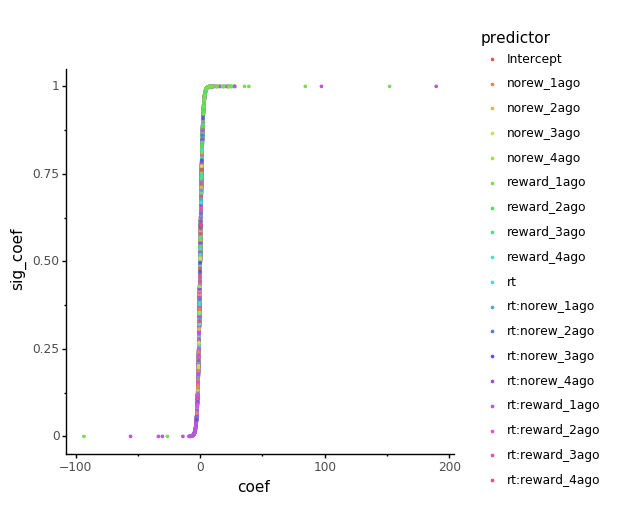

<ggplot: (-9223371906394841109)>

In [37]:
# Check out sigmoided coefficients
gg.options.figure_size = (5, 5)
g = (gg.ggplot(all_model_results, gg.aes('coef', 'sig_coef', color='predictor'))
     + gg.geom_point(size=0.5)
     + gg.coord_cartesian(ylim=(0, 1))
    )
g

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\5_regression_sig_coefs.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 762 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 762 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


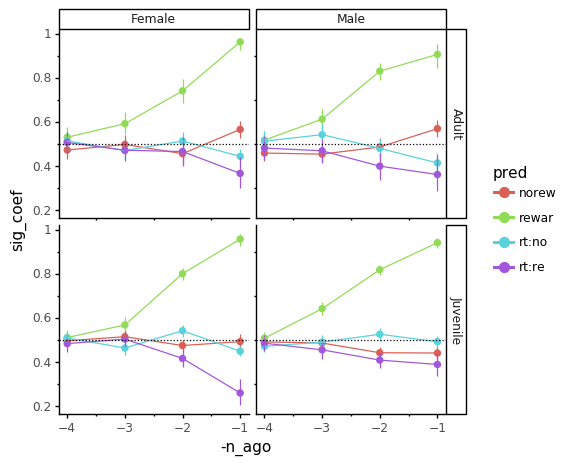

<ggplot: (130461546900)>

In [38]:
# Plot coefficients
g = (gg.ggplot(all_model_results, gg.aes('-n_ago', 'sig_coef', color='pred'))
#      + gg.geom_point(position='jitter', alpha=0.3, size=0.3)
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.geom_hline(yintercept=0.5, linetype='dotted')
     + gg.facet_grid('agegroup ~ sex')
    )
g.save(os.path.join(plot_dir, '5_regression_sig_coefs.png'))
g

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\5_regression_coefs.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 762 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 762 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


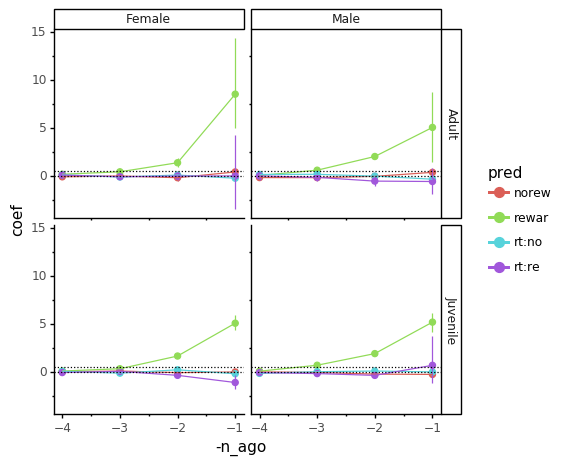

<ggplot: (-9223371906392504786)>

In [39]:
g2 = g + gg.aes(y='coef') + gg.geom_hline(yintercept=0, linetype='dotted')
g2.save(os.path.join(plot_dir, '5_regression_coefs.png'))
g2

### Understanding why

In [22]:
# Making sure everything is coded right:
    # no reward + left (0.0)  => norew -1, reward 0
    # no reward + right (1.0) => norew +1, reward 0
    #    reward + left (0.0)  => reward -1, norew 0
    #    reward + right (1.0) => reward +1, norew 0
true_dat.loc[:30, ['fullID', 'trial', 'reward', 'action', 'reward_1ago', 'norew_1ago', 'stay_1ago', 'stay_2ago', 'switch_1ago']]

,fullID,trial,reward,action,reward_1ago,norew_1ago,stay_1ago,stay_2ago,switch_1ago
0,1404012,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1404012,1,0.0,0.0,-0.0,-1.0,NaN,NaN,NaN
2,1404012,2,1.0,1.0,-0.0,-1.0,NaN,NaN,NaN
3,1404012,3,1.0,1.0,1.0,0.0,NaN,NaN,NaN
4,1404012,4,1.0,1.0,1.0,0.0,NaN,NaN,NaN
5,1404012,5,1.0,1.0,1.0,0.0,NaN,NaN,NaN
6,1404012,6,1.0,1.0,1.0,0.0,NaN,NaN,NaN
7,1404012,7,1.0,1.0,1.0,0.0,NaN,NaN,NaN
8,1404012,8,1.0,1.0,1.0,0.0,NaN,NaN,NaN
9,1404012,9,1.0,1.0,1.0,0.0,NaN,NaN,NaN


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 203 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


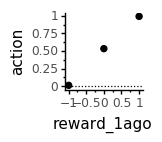

<ggplot: (-9223371906392931356)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 203 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


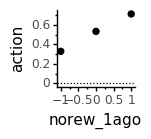

<ggplot: (130461853711)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 389 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


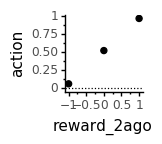

<ggplot: (-9223371906392931580)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 389 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


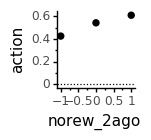

<ggplot: (130467443660)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 556 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


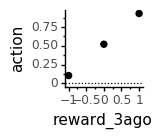

<ggplot: (130467477424)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 556 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


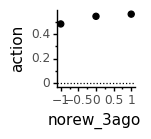

<ggplot: (-9223371906387269453)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 734 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


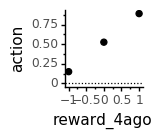

<ggplot: (130467497648)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 734 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


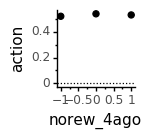

<ggplot: (-9223371906387212435)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 938 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


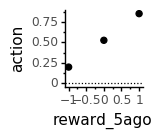

<ggplot: (-9223371906387349311)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 938 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


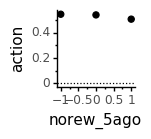

<ggplot: (-9223371906387182525)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1151 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


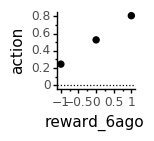

<ggplot: (-9223371906387278178)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1151 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


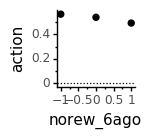

<ggplot: (130461826424)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1379 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


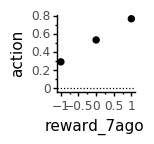

<ggplot: (-9223371906393367450)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1379 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


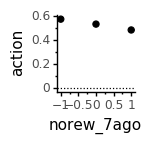

<ggplot: (-9223371906387230748)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1616 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


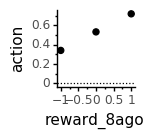

<ggplot: (-9223371906394885446)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1616 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


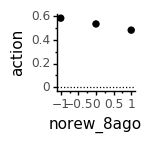

<ggplot: (130460458942)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1846 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


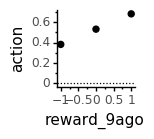

<ggplot: (130460446223)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1846 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


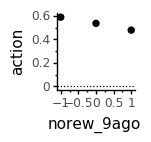

<ggplot: (130460459535)>


In [23]:
gg.options.figure_size = (1, 1)
sub_dat = true_dat.loc[true_dat.rt < 0.5]

for ago in range(1, 10):
    
    # Reward effect looks good: Mice choose left after left-reward, and right after right-reward
    gr = (gg.ggplot(sub_dat, gg.aes('reward_{}ago'.format(ago), 'action'))
         + gg.stat_summary()
         + gg.theme(legend_position='none')
         + gg.geom_hline(yintercept=0, linetype='dotted')
#          + gg.geom_hline(yintercept=1, linetype='dotted')
    )
    print(gr)

    # No reward effect looks wrong: Mice choose left after left-NO reward, and right after right-NO reward
    gn = gr + gg.aes('norew_{}ago'.format(ago))
    print(gn)

#     # Stay looks a little skewed too: Mice repeat right more than left
#     gs = gr + gg.aes('stay_{}ago'.format(ago))
#     print(gs)

gg.options.figure_size = (5, 5)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 388 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


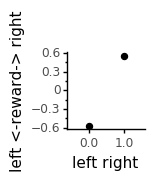

<ggplot: (-9223371906387287548)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 388 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


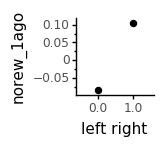

<ggplot: (130461438461)>


PlotnineError: "Could not evaluate the 'y' mapping: 'stay_1ago' (original error: name 'stay_1ago' is not defined)"

In [24]:
gg.options.figure_size = (1, 1)

# Reward effect looks good: Mice choose left after left-reward, and right after right-reward
gr = (gg.ggplot(true_dat, gg.aes('factor(action)', 'reward_1ago'))
     + gg.stat_summary()
     + gg.theme(legend_position='none')
     + gg.labs(x='left right', y='left <-reward-> right')
)
print(gr)

# No reward effect looks wrong: Mice choose left after left-NO reward, and right after right-NO reward
gn = gr + gg.aes(y='norew_1ago')
print(gn)

# Stay looks a little skewed too: Mice repeat right more than left
gs = gr + gg.aes(y='stay_1ago')
print(gs)

gg.options.figure_size = (5, 5)

# OLD

In [ ]:
true_dat['session2'] = 2 * np.round(true_dat.session / 2)
true_dat['session3'] = 3 * np.round(true_dat.session / 3)
sub = true_dat[(true_dat.agegroup == "Juvenile")]
g = (gg.ggplot(sub, gg.aes('age', 'correct', color='factor(session)', group='factor(session)'))
     + gg.stat_summary()
     + gg.stat_summary(geom="line")
     + gg.facet_grid('~ gender')
    )
g

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high) * (true_dat.meta == '1-3')
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
    mean_dat,
).fit().summary())

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high)
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
#     "correct ~ gender + trials2switch + session + agegroup + session:agegroup + trials2switch:session:agegroup + trials2switch:session",
    mean_dat,
).fit().summary())

In [ ]:
# Age group difference in early sessions?
low, hig = 1, 6
sub_dat_t = true_dat[(true_dat.meta == '0-2') * (true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session + agegroup) * (trials2switch + gender + session + agegroup)",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

# Do adults do more meta-learning than juveniles?
sub_dat_t = true_dat[(true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session) * (trials2switch + gender + session) * agegroup",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

In [ ]:
import numpy as np                                                                                         
import statsmodels.api as sm                                                                               
import pandas as pd                                                                                        
                                                                                                           
# create fake data                                                                                         
# y: binary response                                                                                       
# x: continuous predictor                                                                                  
# re: three class random intercepts                                                                        
fakedata = pd.DataFrame({'y' : np.random.sample(50).round(),                                               
                         'x' : np.random.sample(50),                                                       
                         're' : (np.random.sample(50)*2).round().astype(int).astype(str)})
                                                          
# this is implemented as I understand the doc:                                                             
binom_model = sm.BinomialBayesMixedGLM(                                                                    
                                       fakedata['y'], # endog                                              
                                       fakedata['x'][:, None], # exog                                      
                                       pd.get_dummies(fakedata['re']), # Array of covariates for the random
                                       np.r_[0, 0, 0]) # ident, columns of exog_vc                         
binom_result = binom_model.fit_vb()
print(binom_result.summary())

In [ ]:
fakedata

In [ ]:
import numpy as np                                                                                                              
import pandas as pd                                                                                                             
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM, BinomialBayesMixedGLM                                      
                                                                                                                                
n = 1000                                                                                                                        
m = 50 # Number of groups                                                                                                       
grp = np.random.randint(0, m, n)                                                                                                
grp_efx = np.random.normal(size=m)                                                                                              
n_relapse_xmt = np.random.normal(size=n)                                                                                        
lpr = grp_efx[grp] + n_relapse_xmt                                                                                              
mn = np.exp(lpr)                                                                                                                
total_days_AU_MS = np.random.poisson(mn)                                                                                        
X = pd.DataFrame({"total_days_AU_MS": total_days_AU_MS,                                                                         
                  "f_id_site": grp,                                                                                             
                  "n_relapse_xmt": n_relapse_xmt})                                                                              
                                                                                                                                
formula = 'total_days_AU_MS ~ 1 + n_relapse_xmt'                                                                                
                                                                                                                                
glm_model = PoissonBayesMixedGLM.from_formula(formula=formula,                                                                  
                vc_formulas={'f_id_site': '0 + C(f_id_site)'}, data=X)                                                          
glm_results = glm_model.fit_map()                                                                                               
print(glm_results.summary())  

In [ ]:
print(smf.mixedlm(
    "correct ~ (agegroup + session + gender) * (agegroup + session + gender)",
    sub_dat,
    groups=sub_dat.animal
).fit().summary())

In [ ]:
# PC_sim_dir = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat"

In [ ]:
# # Define simulations to be analzed
# n_agents = 100
# PC_sim_name = [f for f in os.listdir(PC_sim_dir) if ('.csv' in f) and ('params' in f)]
# model_names = [modelname.split('_')[1] for modelname in modelnames]
# print(model_names)

In [ ]:

# simulation_dir = os.path.join(PC_sim_dir, 'PC_{}_*.csv'.format(model_name, n_agents))
# if save_or_load_sim_mouse_dat == 'save':
#     sim_dat = pd.read_csv(simulation_dir)
#     sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
# else:
#     sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
# sim_dat = add_meta_column(sim_dat)
# sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))

# # Plot simulated data
# print("Plotting...")
# make_trials2switch_plot(sim_dat, suf='sim' + model_name)
# make_12ago_plot(sim_dat, 'sim' + model_name)
# make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
# make_block_correct_plot(sim_dat, 'sim' + model_name)
# make_session_correct_plot(sim_dat, 'sim' + model_name)
# make_age_reward_plot(sim_dat, 'sim' + model_name)

In [ ]:

# # model_names = [ 'Bbspr', 'Bbp', 'Bbpr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']

# # Read in and format simulated data
# # for PC_sim_name in PC_sim_names:
#     print("Model {}".format(model_name))
#     simulation_dir = os.path.join(PC_sim_dir, 'simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
#     if save_or_load_sim_mouse_dat == 'save':
#         sim_dat = pd.read_csv(simulation_dir)
#         sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
#     else:
#         sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
#     sim_dat = add_meta_column(sim_dat)
#     sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))
    
#     # Plot simulated data
#     print("Plotting...")
#     make_trials2switch_plot(sim_dat, suf='sim' + model_name)
#     make_12ago_plot(sim_dat, 'sim' + model_name)
#     make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
#     make_block_correct_plot(sim_dat, 'sim' + model_name)
#     make_session_correct_plot(sim_dat, 'sim' + model_name)
#     make_age_reward_plot(sim_dat, 'sim' + model_name)